In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [2]:
data = pd.read_csv('QVI_data.csv')
data.head(10)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream
5,1005,2018-12-28,1,6,86,Cheetos Puffs 165g,1,2.8,165,CHEETOS,MIDAGE SINGLES/COUPLES,Mainstream
6,1007,2018-12-04,1,7,49,Infuzions SourCream&Herbs Veg Strws 110g,1,3.8,110,INFUZIONS,YOUNG SINGLES/COUPLES,Budget
7,1007,2018-12-05,1,8,10,RRD SR Slow Rst Pork Belly 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Budget
8,1009,2018-11-20,1,9,20,Doritos Cheese Supreme 330g,1,5.7,330,DORITOS,NEW FAMILIES,Premium
9,1010,2018-09-09,1,10,51,Doritos Mexicana 170g,2,8.8,170,DORITOS,YOUNG SINGLES/COUPLES,Mainstream


In [3]:
data['DATE'] = pd.to_datetime(data['DATE'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int64         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  int64         
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 24.2+ MB


In [4]:
data['YEAR_MONTH'] = data['DATE'].dt.to_period('M')

In [5]:
measures = data.groupby(['STORE_NBR', 'YEAR_MONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxn=('TXN_ID', 'nunique'), nChips=('PROD_QTY','sum')).reset_index().sort_values(by=['STORE_NBR', 'YEAR_MONTH'])

In [6]:
measures['nTxnPerCust'] = measures['nTxn']/measures['nCustomers']
measures['nChipsPerTxn'] = measures['nChips']/measures['nTxn']
measures['avgPricePerUnit'] = measures['totSales']/measures['nChips']

In [7]:
measures

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,nTxn,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,2018-07,206.9,49,52,62,1.061224,1.192308,3.337097
1,1,2018-08,176.1,42,43,54,1.023810,1.255814,3.261111
2,1,2018-09,278.8,59,62,75,1.050847,1.209677,3.717333
3,1,2018-10,188.1,44,45,58,1.022727,1.288889,3.243103
4,1,2018-11,192.6,46,47,57,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...,...,...
3164,272,2019-02,395.5,45,48,91,1.066667,1.895833,4.346154
3165,272,2019-03,442.3,50,53,101,1.060000,1.905660,4.379208
3166,272,2019-04,445.1,54,55,105,1.018519,1.909091,4.239048
3167,272,2019-05,314.6,34,40,71,1.176471,1.775000,4.430986


In [8]:
fullObs = {}
for i in measures['STORE_NBR'].unique() :
    fullObs[i]= measures.loc[measures['STORE_NBR']==i, 'YEAR_MONTH'].count()
Obs = pd.DataFrame(fullObs.items(), columns=['STORE_NBR', 'MONTH_OBS'])
storesWithFullObs = Obs.loc[Obs['MONTH_OBS']==12, 'STORE_NBR']
preTrial = measures[(measures['YEAR_MONTH'] < '2019-02') & (measures['STORE_NBR'].isin(storesWithFullObs))]

In [9]:
def storecorr(inputTable, metricCol, storeComparison) :
    storeNumber = inputTable['STORE_NBR'].unique()
    caculatedMeasure = pd.DataFrame(columns=['Store1','Store2','Corr'])
    for i in storeNumber :
        caculatedMeasure.loc[i, 'Store1'] = storeComparison
        caculatedMeasure.loc[i, 'Store2'] = i 
        caculatedMeasure.loc[i, 'Corr'] =  np.corrcoef(inputTable.loc[inputTable['STORE_NBR'] == storeComparison, metricCol], \
                                                inputTable.loc[inputTable['STORE_NBR'] == i, metricCol])[1,0]
    
    return caculatedMeasure.reset_index(drop=True)

In [10]:
def calculateMagnitudeDistance(inputTable, metricCol, storeComparison) :
    storeNumber = preTrial['STORE_NBR'].unique()
    month = preTrial.loc[preTrial['STORE_NBR'] == storeComparison,'YEAR_MONTH'].unique()
    store1 = []
    store2 = []
    year_month = []
    measure = []
    for j in month : 
        for i in storeNumber:
            year_month.append(j) 
            store1.append(storeComparison) 
            store2.append(i)
            measure.append(np.abs(int(preTrial.loc[(preTrial['STORE_NBR'] == storeComparison)\
                                                    & (preTrial['YEAR_MONTH'] == j), metricCol]) \
                                                    - int(preTrial.loc[(preTrial['STORE_NBR'] == i) & \
                                                    (preTrial['YEAR_MONTH'] == j), metricCol])))

    calcDistTable = pd.DataFrame({'Store1': store1, 'Store2': store2, 'Year_Month': year_month, 'Measure': measure })
    minMaxDist = calcDistTable.groupby(['Store1', 'Year_Month']).agg(\
                minDist=('Measure', 'min'), maxDist=('Measure', 'max'))
    distTable = pd.merge(calcDistTable, minMaxDist, on =['Store1','Year_Month'])
    distTable['magnitudeMeasure'] = 1 - (distTable['Measure'] - distTable['minDist'])\
    /(distTable['maxDist'] - distTable['minDist'])
    finalDistTable = distTable.groupby(['Store1','Store2']).agg(mag_measure=('magnitudeMeasure','mean'))
    
    return finalDistTable

## Trial store 77

In [11]:
trial_store = 77
corr_nSales = storecorr(preTrial, 'totSales', trial_store)
corr_nCustomers = storecorr(preTrial, 'nCustomers', trial_store)

In [12]:
magnitude_nSales = calculateMagnitudeDistance(preTrial, 'totSales', trial_store)
magnitude_nCustomers  = calculateMagnitudeDistance(preTrial, 'nCustomers', trial_store)

In [13]:
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on = ['Store1', 'Store2'])
score_nSales['scoreNSales'] = score_nSales['Corr'] * corr_weight + score_nSales['mag_measure'] * (1-corr_weight)
score_nSales

,Store1,Store2,Corr,mag_measure,scoreNSales
0,77,1,0.075218,0.953331,0.514274
1,77,2,-0.263079,0.937408,0.337165
2,77,3,0.806644,0.354442,0.580543
3,77,4,-0.2633,0.177149,-0.043075
4,77,5,-0.110652,0.552776,0.221062
...,...,...,...,...,...
255,77,268,0.344757,0.960835,0.652796
256,77,269,-0.31573,0.451968,0.068119
257,77,270,0.31543,0.446077,0.380754
258,77,271,0.355487,0.552340,0.453914


In [14]:
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on = ['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['Corr'] * corr_weight + score_nCustomers['mag_measure'] * (1-corr_weight)

In [15]:
store_Control = pd.merge(score_nSales, score_nCustomers, on = ['Store1', 'Store2'])
store_Control['finalControlScore'] = store_Control['scoreNCust'] * 0.5 + store_Control['scoreNSales'] * 0.5
store_Control = store_Control.sort_values(by='finalControlScore', ascending=False).reset_index(drop=True)
store_Control

,Store1,Store2,Corr_x,mag_measure_x,scoreNSales,Corr_y,mag_measure_y,scoreNCust,finalControlScore
0,77,77,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0
1,77,233,0.903774,0.985360,0.944567,0.990358,0.992773,0.991566,0.968066
2,77,41,0.783232,0.965181,0.874207,0.844219,0.974639,0.909429,0.891818
3,77,17,0.842668,0.880608,0.861638,0.747308,0.962495,0.854902,0.85827
4,77,254,0.577108,0.922696,0.749902,0.916208,0.937131,0.92667,0.838286
...,...,...,...,...,...,...,...,...,...
255,77,55,-0.666782,0.469425,-0.098678,-0.395473,0.379737,-0.007868,-0.053273
256,77,138,-0.585174,0.491336,-0.046919,-0.534877,0.387474,-0.073702,-0.06031
257,77,247,-0.63105,0.526268,-0.052391,-0.621034,0.427865,-0.096585,-0.074488
258,77,102,-0.550834,0.488415,-0.031209,-0.652527,0.396846,-0.127841,-0.079525


In [16]:
control_store = store_Control['Store2'][1]
control_store #The store with the highest score is then selected as the control store

233

In [17]:
measureOverTimeSales = measures 
measureOverTimeSales

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,nTxn,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,2018-07,206.9,49,52,62,1.061224,1.192308,3.337097
1,1,2018-08,176.1,42,43,54,1.023810,1.255814,3.261111
2,1,2018-09,278.8,59,62,75,1.050847,1.209677,3.717333
3,1,2018-10,188.1,44,45,58,1.022727,1.288889,3.243103
4,1,2018-11,192.6,46,47,57,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...,...,...
3164,272,2019-02,395.5,45,48,91,1.066667,1.895833,4.346154
3165,272,2019-03,442.3,50,53,101,1.060000,1.905660,4.379208
3166,272,2019-04,445.1,54,55,105,1.018519,1.909091,4.239048
3167,272,2019-05,314.6,34,40,71,1.176471,1.775000,4.430986


In [18]:
for i in range(len(measureOverTimeSales)) :
    if measureOverTimeSales.loc[i, 'STORE_NBR'] == trial_store :
        measureOverTimeSales.loc[i, 'Store_Type'] = 'Trial'
    elif measureOverTimeSales.loc[i, 'STORE_NBR'] == control_store :
        measureOverTimeSales.loc[i, 'Store_Type'] = 'Control'
    else : 
        measureOverTimeSales.loc[i, 'Store_Type'] = 'Others'

In [19]:
measure_preTrial = measureOverTimeSales[measureOverTimeSales['YEAR_MONTH'] < '2019-03']
pastSales = measure_preTrial.pivot_table(index='YEAR_MONTH', columns='Store_Type', values='totSales', aggfunc='mean')

<Figure size 800x600 with 0 Axes>

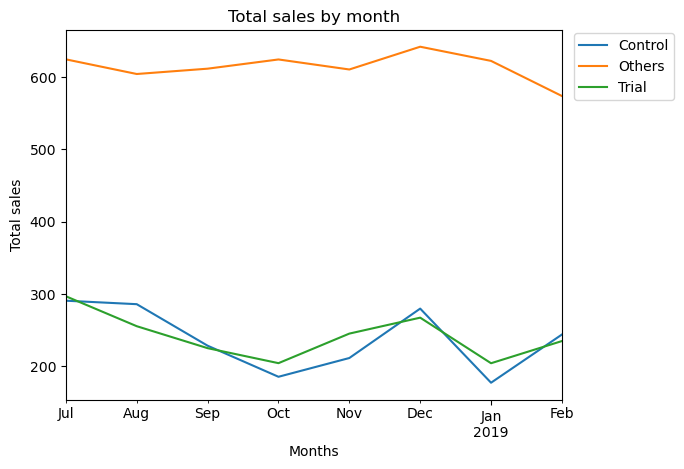

In [20]:
import matplotlib as mpl

plt.figure(figsize=[8,6])
pastSales.plot()
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.title('Total sales by month')
plt.ylabel('Total sales')
plt.xlabel('Months')
plt.show()

<Figure size 800x600 with 0 Axes>

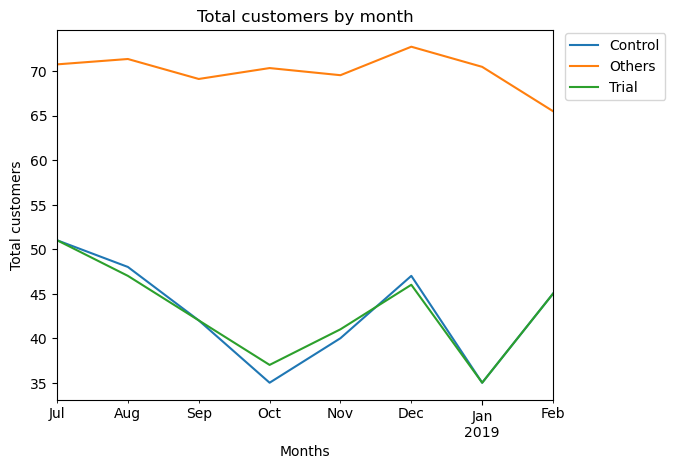

In [21]:
pastCust = measure_preTrial.pivot_table(index='YEAR_MONTH', columns='Store_Type', values='nCustomers', aggfunc='mean')

plt.figure(figsize=[8,6])
pastCust.plot()
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.title('Total customers by month')
plt.ylabel('Total customers')
plt.xlabel('Months')
plt.show()

### Assessment of Trial

#### Total Sales

In [22]:
trial_sales = preTrial.loc[(preTrial['STORE_NBR'] == trial_store) & (preTrial['YEAR_MONTH'] < '2019-02'), 'totSales'].sum()
control_sales = preTrial.loc[(preTrial['STORE_NBR'] == control_store) & (preTrial['YEAR_MONTH'] < '2019-02'), 'totSales'].sum()
scalingFactorForControlSales = trial_sales / control_sales

In [23]:
scaledSales = measureOverTimeSales
scaledSales['controlSales'] = scaledSales.loc[scaledSales['STORE_NBR'] == control_store,\
                                                        'totSales']*scalingFactorForControlSales
scaledControlSales = scaledSales[scaledSales['STORE_NBR'] == control_store]
scaledControlSales

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,nTxn,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,controlSales
2699,233,2018-07,290.7,51,54,88,1.058824,1.629630,3.303409,Control,297.565550
2700,233,2018-08,285.9,48,50,80,1.041667,1.600000,3.573750,Control,292.652187
2701,233,2018-09,228.6,42,45,70,1.071429,1.555556,3.265714,Control,233.998916
2702,233,2018-10,185.7,35,36,56,1.028571,1.555556,3.316071,Control,190.085733
2703,233,2018-11,211.6,40,41,62,1.025000,1.512195,3.412903,Control,216.597421
2704,233,2018-12,279.8,47,50,75,1.063830,1.500000,3.730667,Control,286.408121
2705,233,2019-01,177.5,35,35,47,1.000000,1.342857,3.776596,Control,181.692071
2706,233,2019-02,244.0,45,47,70,1.044444,1.489362,3.485714,Control,249.762622
2707,233,2019-03,199.1,40,41,59,1.025000,1.439024,3.374576,Control,203.802205
2708,233,2019-04,158.6,30,32,46,1.066667,1.437500,3.447826,Control,162.345704


In [24]:
percentageDiff = pd.merge(scaledControlSales[['YEAR_MONTH','controlSales']],\
                          measures.loc[measures['STORE_NBR']==trial_store,['totSales','YEAR_MONTH']])

percentageDiff['percentageDiff'] = np.abs((percentageDiff['controlSales'] - percentageDiff['totSales'])/percentageDiff['controlSales'])

In [25]:
percentageDiff

,YEAR_MONTH,controlSales,totSales,percentageDiff
0,2018-07,297.565550,296.8,0.002573
1,2018-08,292.652187,255.5,0.126950
2,2018-09,233.998916,225.2,0.037602
3,2018-10,190.085733,204.5,0.075830
4,2018-11,216.597421,245.3,0.132516
5,2018-12,286.408121,267.3,0.066716
6,2019-01,181.692071,204.4,0.124980
7,2019-02,249.762622,235.0,0.059107
8,2019-03,203.802205,278.5,0.366521
9,2019-04,162.345704,263.5,0.623080


In [26]:
stdDev = np.std(percentageDiff.loc[percentageDiff['YEAR_MONTH']<'2019-02', 'percentageDiff'])
dof = 8 - 1
percentageDiff['tValues'] = (percentageDiff['percentageDiff'] - 0)/stdDev
percentageDiff.loc[(percentageDiff['YEAR_MONTH']<'2019-05') & (percentageDiff['YEAR_MONTH']>'2019-01'), ['tValues','YEAR_MONTH']]

,tValues,YEAR_MONTH
7,1.278363,2019-02
8,7.927151,2019-03
9,13.476023,2019-04


In [27]:
from scipy.stats import t
percentile = t.ppf(0.95, df=dof)
percentile

1.894578605061305

T-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

In [28]:
pastSales_1 = measureOverTimeSales.loc[(measureOverTimeSales['Store_Type']=='Trial') | \
                                       (measureOverTimeSales['Store_Type']=='Control'),\
                                       ['YEAR_MONTH','Store_Type','totSales']]

In [29]:
pastSales_Controls95 = pastSales_1[pastSales_1['Store_Type'] == 'Control']
pastSales_Controls95['totSales'] = pastSales_1['totSales'] * (1 + stdDev * 2) 
pastSales_Controls95['Store_Type'] = 'Control 95th % confidence'

pastSales_Controls5 = pastSales_1[pastSales_1['Store_Type'] == 'Control']
pastSales_Controls5['totSales'] = pastSales_1['totSales'] * (1 - stdDev * 2) 
pastSales_Controls5['Store_Type'] = 'Control 5th % confidence'

/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/2125521922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls95['totSales'] = pastSales_1['totSales'] * (1 + stdDev * 2)
/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/2125521922.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls95['Store_Type'] = 'Control 95th % confidence'
/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/2125521922.py:6: SettingWithCopyWarning: 
A valu

In [30]:
trialAssessment = pd.concat([pastSales_1 , pastSales_Controls95, pastSales_Controls5], axis=0)
trialAssessment['YEAR_MONTH'] = trialAssessment['YEAR_MONTH'].dt.to_timestamp()
trialAssessment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 880 to 2710
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   YEAR_MONTH  48 non-null     datetime64[ns]
 1   Store_Type  48 non-null     object        
 2   totSales    48 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.5+ KB


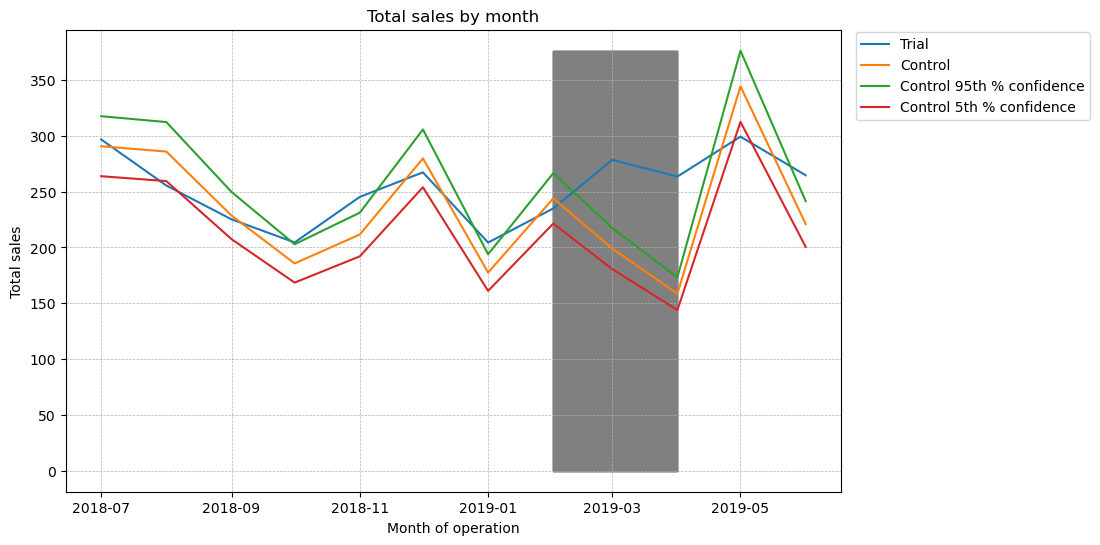

In [31]:
import seaborn as sns

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=trialAssessment, x='YEAR_MONTH', y='totSales',  hue='Store_Type')
plt.rc('axes', axisbelow=True)

# Customize plot
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.fill_between(trialAssessment.YEAR_MONTH, trialAssessment.totSales.max(),\
                 where= (trialAssessment.YEAR_MONTH<'2019-05') & (trialAssessment.YEAR_MONTH>'2019-01'), color='grey')
plt.show()

The trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

In [32]:
preTrial

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,nTxn,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,2018-07,206.9,49,52,62,1.061224,1.192308,3.337097
1,1,2018-08,176.1,42,43,54,1.023810,1.255814,3.261111
2,1,2018-09,278.8,59,62,75,1.050847,1.209677,3.717333
3,1,2018-10,188.1,44,45,58,1.022727,1.288889,3.243103
4,1,2018-11,192.6,46,47,57,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...,...,...
3159,272,2018-09,304.7,32,36,71,1.125000,1.972222,4.291549
3160,272,2018-10,430.6,44,50,99,1.136364,1.980000,4.349495
3161,272,2018-11,376.2,41,45,87,1.097561,1.933333,4.324138
3162,272,2018-12,403.9,47,47,89,1.000000,1.893617,4.538202


#### Number of customers

In [33]:
trial_cust = preTrial.loc[(preTrial['STORE_NBR'] == trial_store) & (preTrial['YEAR_MONTH'] < '2019-02'), 'nCustomers'].sum()
control_cust = preTrial.loc[(preTrial['STORE_NBR'] == control_store) & (preTrial['YEAR_MONTH'] < '2019-02'), 'nCustomers'].sum()
scalingFactorForControlCust = trial_cust / control_cust

scaledCust = measureOverTimeSales
scaledCust['controlCustomers'] = scaledCust.loc[scaledCust['STORE_NBR'] == control_store,\
                                                        'nCustomers']*scalingFactorForControlCust
scaledControlCust = scaledCust[scaledCust['STORE_NBR'] == control_store]

In [34]:
percentageDiff_cust = pd.merge(scaledControlCust[['YEAR_MONTH','controlCustomers']],\
                          measures.loc[measures['STORE_NBR']==trial_store,['nCustomers','YEAR_MONTH']])

percentageDiff_cust['percentageDiff'] = np.abs((percentageDiff_cust['controlCustomers'] - percentageDiff_cust['nCustomers'])/percentageDiff_cust['controlCustomers'])

In [35]:
percentageDiff_cust

,YEAR_MONTH,controlCustomers,nCustomers,percentageDiff
0,2018-07,51.171141,51,0.003344
1,2018-08,48.161074,47,0.024108
2,2018-09,42.140940,42,0.003344
3,2018-10,35.117450,37,0.053607
4,2018-11,40.134228,41,0.021572
5,2018-12,47.157718,46,0.024550
6,2019-01,35.117450,35,0.003344
7,2019-02,45.151007,45,0.003344
8,2019-03,40.134228,50,0.245819
9,2019-04,30.100671,47,0.561427


In [36]:
stdDev_cust = np.std(percentageDiff_cust.loc[percentageDiff_cust['YEAR_MONTH']<'2019-02', 'percentageDiff'])
percentageDiff_cust['tValues'] = (percentageDiff_cust['percentageDiff'] - 0)/stdDev_cust
percentageDiff_cust.loc[(percentageDiff_cust['YEAR_MONTH']<'2019-05') & (percentageDiff_cust['YEAR_MONTH']>'2019-01'), ['tValues','YEAR_MONTH']]

,tValues,YEAR_MONTH
7,0.198043,2019-02
8,14.556162,2019-03
9,33.244822,2019-04


In [37]:
pastCustomer = measureOverTimeSales.loc[(measureOverTimeSales['Store_Type']=='Trial') | \
                                       (measureOverTimeSales['Store_Type']=='Control'),\
                                       ['YEAR_MONTH','Store_Type','nCustomers']]

pastCustomer_Controls95 = pastCustomer[pastCustomer['Store_Type'] == 'Control']
pastCustomer_Controls95['nCustomers'] = pastCustomer['nCustomers'] * (1 + stdDev_cust * 2) 
pastCustomer_Controls95['Store_Type'] = 'Control 95th % confidence'

pastCustomer_Controls5 = pastCustomer[pastCustomer['Store_Type'] == 'Control']
pastCustomer_Controls5['nCustomers'] = pastCustomer['nCustomers'] * (1 - stdDev_cust * 2) 
pastCustomer_Controls5['Store_Type'] = 'Control 5th % confidence'

/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/863260651.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastCustomer_Controls95['nCustomers'] = pastCustomer['nCustomers'] * (1 + stdDev_cust * 2)
/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/863260651.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastCustomer_Controls95['Store_Type'] = 'Control 95th % confidence'
/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/863260651.py:10: SettingWithCopyWa

In [38]:
trialAssessment_cust = pd.concat([pastCustomer , pastCustomer_Controls95, pastCustomer_Controls5], axis=0)
trialAssessment_cust['YEAR_MONTH'] = trialAssessment_cust['YEAR_MONTH'].dt.to_timestamp()
trialAssessment_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 880 to 2710
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   YEAR_MONTH  48 non-null     datetime64[ns]
 1   Store_Type  48 non-null     object        
 2   nCustomers  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.5+ KB


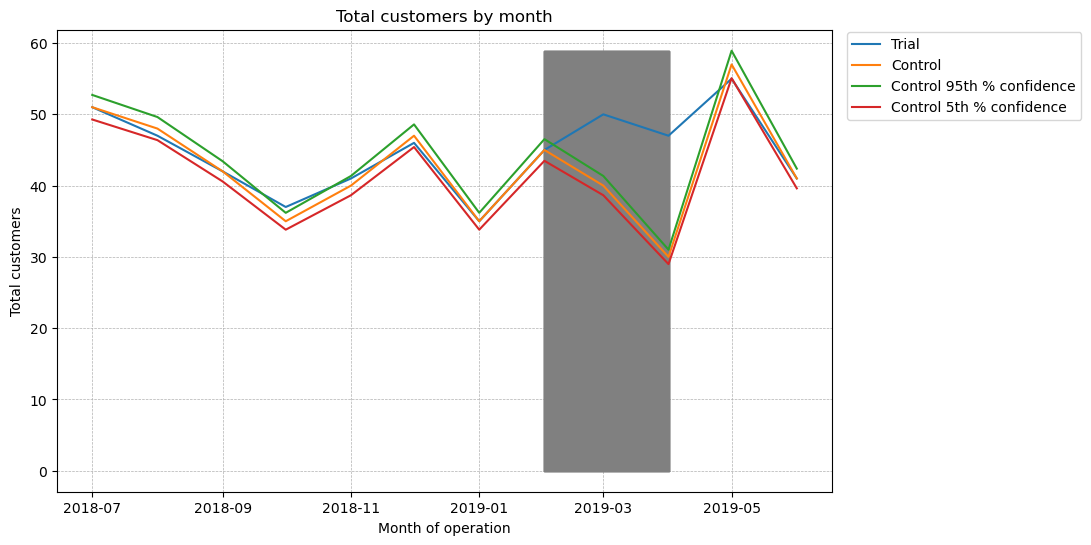

In [39]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=trialAssessment_cust, x='YEAR_MONTH', y='nCustomers',  hue='Store_Type')
plt.rc('axes', axisbelow=True)

# Customize plot
plt.xlabel('Month of operation')
plt.ylabel('Total customers')
plt.title('Total customers by month')
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.fill_between(trialAssessment_cust.YEAR_MONTH, trialAssessment_cust.nCustomers.max(),\
                 where= (trialAssessment_cust.YEAR_MONTH<'2019-05') & (trialAssessment_cust.YEAR_MONTH>'2019-01'), color='grey')
plt.show()

## Trial store 86

In [40]:
trial_store = 86
corr_nSales = storecorr(preTrial, 'totSales', trial_store)
corr_nCustomers = storecorr(preTrial, 'nCustomers', trial_store)

In [41]:
magnitude_nSales = calculateMagnitudeDistance(preTrial, 'totSales', trial_store)
magnitude_nCustomers  = calculateMagnitudeDistance(preTrial, 'nCustomers', trial_store)

In [42]:
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on = ['Store1', 'Store2'])
score_nSales['scoreNSales'] = score_nSales['Corr'] * corr_weight + score_nSales['mag_measure'] * (1-corr_weight)
score_nSales

,Store1,Store2,Corr,mag_measure,scoreNSales
0,86,1,0.445632,0.220082,0.332857
1,86,2,-0.403835,0.179108,-0.112364
2,86,3,-0.261284,0.761736,0.250226
3,86,4,-0.039035,0.497754,0.229359
4,86,5,0.235159,0.927934,0.581547
...,...,...,...,...,...
255,86,268,-0.452182,0.250355,-0.100913
256,86,269,0.697055,0.900506,0.798781
257,86,270,-0.730679,0.833171,0.051246
258,86,271,0.527637,0.921132,0.724385


In [43]:
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on = ['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['Corr'] * corr_weight + score_nCustomers['mag_measure'] * (1-corr_weight)

In [44]:
store_Control = pd.merge(score_nSales, score_nCustomers, on = ['Store1', 'Store2'])
store_Control['finalControlScore'] = store_Control['scoreNCust'] * 0.5 + store_Control['scoreNSales'] * 0.5
store_Control = store_Control.sort_values(by='finalControlScore', ascending=False).reset_index(drop=True)
store_Control

,Store1,Store2,Corr_x,mag_measure_x,scoreNSales,Corr_y,mag_measure_y,scoreNCust,finalControlScore
0,86,86,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0
1,86,155,0.877882,0.963202,0.920542,0.942876,0.985037,0.963956,0.942249
2,86,109,0.7883,0.962369,0.875334,0.770778,0.965940,0.868359,0.871847
3,86,114,0.734415,0.919553,0.826984,0.855339,0.935508,0.895424,0.861204
4,86,138,0.759864,0.923742,0.841803,0.749701,0.928031,0.838866,0.840334
...,...,...,...,...,...,...,...,...,...
255,86,108,-0.840413,0.341361,-0.249526,-0.697245,0.344397,-0.176424,-0.212975
256,86,52,-0.601629,0.034341,-0.283644,-0.594459,0.041166,-0.276647,-0.280146
257,86,120,-0.872693,0.172776,-0.349959,-0.815097,0.375671,-0.219713,-0.284836
258,86,42,-0.74572,0.019883,-0.362918,-0.664952,0.040272,-0.31234,-0.337629


In [45]:
control_store = store_Control['Store2'][1]
control_store

155

In [46]:
measureOverTimeSales = measures 
measureOverTimeSales

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,nTxn,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,controlSales,controlCustomers
0,1,2018-07,206.9,49,52,62,1.061224,1.192308,3.337097,Others,NaN,NaN
1,1,2018-08,176.1,42,43,54,1.023810,1.255814,3.261111,Others,NaN,NaN
2,1,2018-09,278.8,59,62,75,1.050847,1.209677,3.717333,Others,NaN,NaN
3,1,2018-10,188.1,44,45,58,1.022727,1.288889,3.243103,Others,NaN,NaN
4,1,2018-11,192.6,46,47,57,1.021739,1.212766,3.378947,Others,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3164,272,2019-02,395.5,45,48,91,1.066667,1.895833,4.346154,Others,NaN,NaN
3165,272,2019-03,442.3,50,53,101,1.060000,1.905660,4.379208,Others,NaN,NaN
3166,272,2019-04,445.1,54,55,105,1.018519,1.909091,4.239048,Others,NaN,NaN
3167,272,2019-05,314.6,34,40,71,1.176471,1.775000,4.430986,Others,NaN,NaN


In [47]:
for i in range(len(measureOverTimeSales)) :
    if measureOverTimeSales.loc[i, 'STORE_NBR'] == trial_store :
        measureOverTimeSales.loc[i, 'Store_Type'] = 'Trial'
    elif measureOverTimeSales.loc[i, 'STORE_NBR'] == control_store :
        measureOverTimeSales.loc[i, 'Store_Type'] = 'Control'
    else : 
        measureOverTimeSales.loc[i, 'Store_Type'] = 'Others'

In [48]:
measure_preTrial = measureOverTimeSales[measureOverTimeSales['YEAR_MONTH'] < '2019-03']
pastSales = measure_preTrial.pivot_table(index='YEAR_MONTH', columns='Store_Type', values='totSales', aggfunc='mean')

<Figure size 800x600 with 0 Axes>

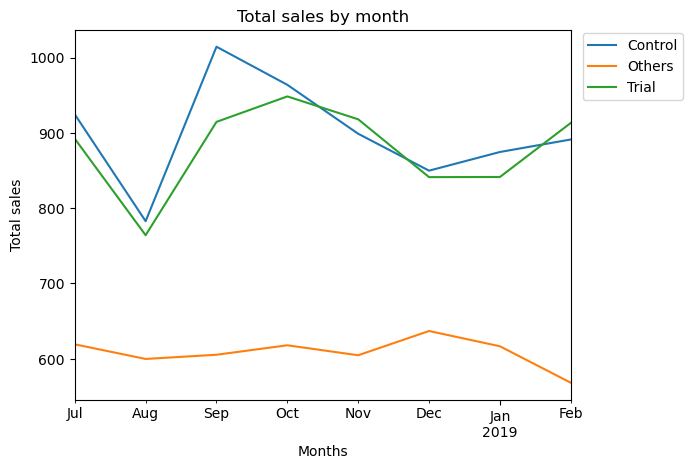

In [49]:
plt.figure(figsize=[8,6])
pastSales.plot()
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.title('Total sales by month')
plt.ylabel('Total sales')
plt.xlabel('Months')
plt.show()

<Figure size 800x600 with 0 Axes>

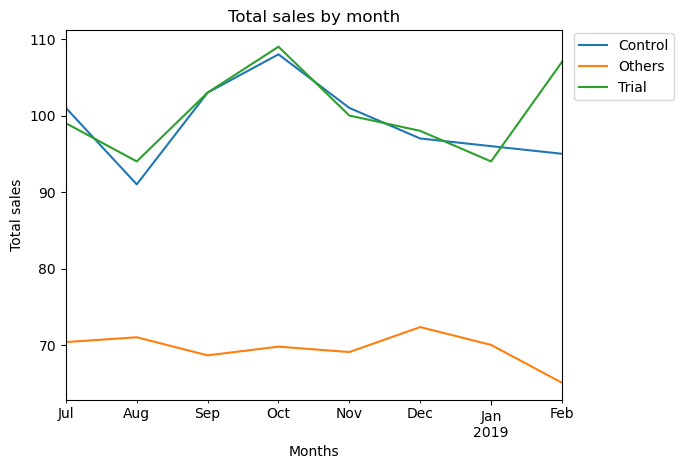

In [50]:
pastCust = measure_preTrial.pivot_table(index='YEAR_MONTH', columns='Store_Type', values='nCustomers', aggfunc='mean')

plt.figure(figsize=[8,6])
pastCust.plot()
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.title('Total sales by month')
plt.ylabel('Total sales')
plt.xlabel('Months')
plt.show()

### Assessment of Trial

#### Total sales

In [51]:
trial_sales = preTrial.loc[(preTrial['STORE_NBR'] == trial_store) & (preTrial['YEAR_MONTH'] < '2019-02'), 'totSales'].sum()
control_sales = preTrial.loc[(preTrial['STORE_NBR'] == control_store) & (preTrial['YEAR_MONTH'] < '2019-02'), 'totSales'].sum()
scalingFactorForControlSales = trial_sales / control_sales

In [52]:
scaledSales = measureOverTimeSales
scaledSales['controlSales'] = scaledSales.loc[scaledSales['STORE_NBR'] == control_store,\
                                                        'totSales']*scalingFactorForControlSales
scaledControlSales = scaledSales[scaledSales['STORE_NBR'] == control_store]
scaledControlSales

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,nTxn,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,controlSales,controlCustomers
1793,155,2018-07,924.60,101,123,250,1.217822,2.032520,3.698400,Control,896.922236,NaN
1794,155,2018-08,782.70,91,119,229,1.307692,1.924370,3.417904,Control,759.269991,NaN
1795,155,2018-09,1014.40,103,144,290,1.398058,2.013889,3.497931,Control,984.034086,NaN
1796,155,2018-10,963.80,108,136,272,1.259259,2.000000,3.543382,Control,934.948790,NaN
1797,155,2018-11,898.80,101,133,270,1.316832,2.030075,3.328889,Control,871.894555,NaN
1798,155,2018-12,849.80,97,120,242,1.237113,2.016667,3.511570,Control,824.361363,NaN
1799,155,2019-01,874.60,96,125,252,1.302083,2.016000,3.470635,Control,848.418979,NaN
1800,155,2019-02,891.20,95,125,254,1.315789,2.032000,3.508661,Control,864.522060,NaN
1801,155,2019-03,804.40,94,118,240,1.255319,2.033898,3.351667,Control,780.320405,NaN
1802,155,2019-04,844.60,99,120,242,1.212121,2.016667,3.490083,Control,819.317024,NaN


In [53]:
percentageDiff = pd.merge(scaledControlSales[['YEAR_MONTH','controlSales']],\
                          measures.loc[measures['STORE_NBR']==trial_store,['totSales','YEAR_MONTH']])

percentageDiff['percentageDiff'] = np.abs((percentageDiff['controlSales'] - percentageDiff['totSales'])/percentageDiff['controlSales'])
percentageDiff

,YEAR_MONTH,controlSales,totSales,percentageDiff
0,2018-07,896.922236,892.20,0.005265
1,2018-08,759.269991,764.05,0.006296
2,2018-09,984.034086,914.60,0.070561
3,2018-10,934.948790,948.40,0.014387
4,2018-11,871.894555,918.00,0.052880
5,2018-12,824.361363,841.20,0.020426
6,2019-01,848.418979,841.40,0.008273
7,2019-02,864.522060,913.20,0.056306
8,2019-03,780.320405,1026.80,0.315870
9,2019-04,819.317024,848.20,0.035253


In [54]:
stdDev = np.std(percentageDiff.loc[percentageDiff['YEAR_MONTH']<'2019-02', 'percentageDiff'])
dof = 8 - 1
percentageDiff['tValues'] = (percentageDiff['percentageDiff'] - 0)/stdDev
percentageDiff.loc[(percentageDiff['YEAR_MONTH']<'2019-05') & (percentageDiff['YEAR_MONTH']>'2019-01'), ['tValues','YEAR_MONTH']]

,tValues,YEAR_MONTH
7,2.354174,2019-02
8,13.206585,2019-03
9,1.473915,2019-04


In [55]:
from scipy.stats import t
percentile = t.ppf(0.95, df=dof)
percentile

1.894578605061305

T-value is much larger than the 95th percentile value of the t-distribution for February and March - i.e. the increase in sales in the trial store in February and March is statistically greater than in the control store.

In [56]:
pastSales_1 = measureOverTimeSales.loc[(measureOverTimeSales['Store_Type']=='Trial') | \
                                       (measureOverTimeSales['Store_Type']=='Control'),\
                                       ['YEAR_MONTH','Store_Type','totSales']]

In [57]:
pastSales_Controls95 = pastSales_1[pastSales_1['Store_Type'] == 'Control']
pastSales_Controls95['totSales'] = pastSales_1['totSales'] * (1 + stdDev * 2) 
pastSales_Controls95['Store_Type'] = 'Control 95th % confidence'

pastSales_Controls5 = pastSales_1[pastSales_1['Store_Type'] == 'Control']
pastSales_Controls5['totSales'] = pastSales_1['totSales'] * (1 - stdDev * 2) 
pastSales_Controls5['Store_Type'] = 'Control 5th % confidence'

/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/2125521922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls95['totSales'] = pastSales_1['totSales'] * (1 + stdDev * 2)
/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/2125521922.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls95['Store_Type'] = 'Control 95th % confidence'
/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/2125521922.py:6: SettingWithCopyWarning: 
A valu

In [58]:
trialAssessment = pd.concat([pastSales_1 , pastSales_Controls95, pastSales_Controls5], axis=0)
trialAssessment['YEAR_MONTH'] = trialAssessment['YEAR_MONTH'].dt.to_timestamp()
trialAssessment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 977 to 1804
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   YEAR_MONTH  48 non-null     datetime64[ns]
 1   Store_Type  48 non-null     object        
 2   totSales    48 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.5+ KB


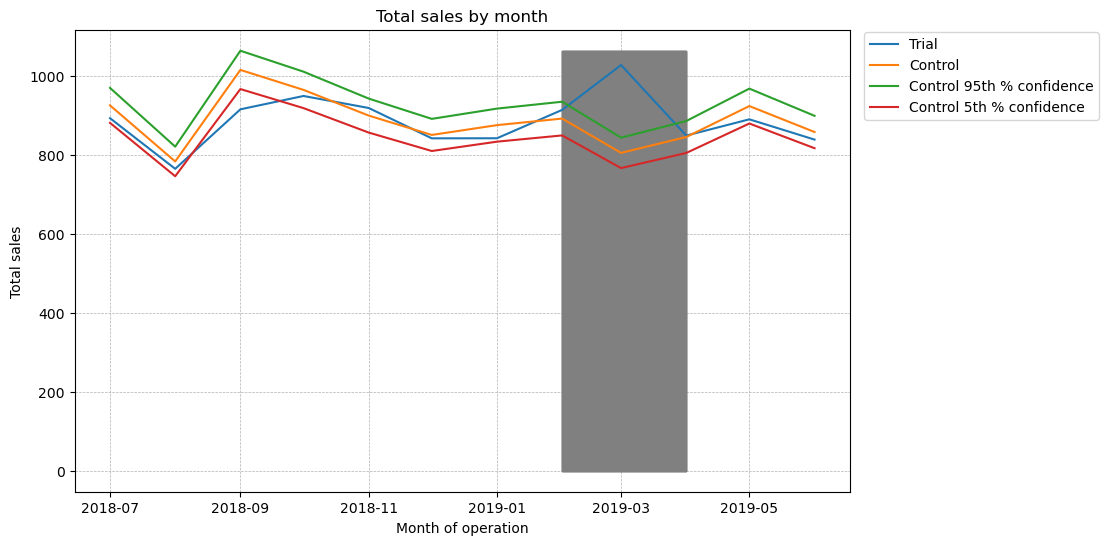

In [59]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=trialAssessment, x='YEAR_MONTH', y='totSales',  hue='Store_Type')
plt.rc('axes', axisbelow=True)

# Customize plot
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.fill_between(trialAssessment.YEAR_MONTH, trialAssessment.totSales.max(),\
                 where= (trialAssessment.YEAR_MONTH<'2019-05') & (trialAssessment.YEAR_MONTH>'2019-01'), color='grey')
plt.show()

The trial in store 86 is not significantly different to its control store in the trial period as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.

In [60]:
preTrial

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,nTxn,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,2018-07,206.9,49,52,62,1.061224,1.192308,3.337097
1,1,2018-08,176.1,42,43,54,1.023810,1.255814,3.261111
2,1,2018-09,278.8,59,62,75,1.050847,1.209677,3.717333
3,1,2018-10,188.1,44,45,58,1.022727,1.288889,3.243103
4,1,2018-11,192.6,46,47,57,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...,...,...
3159,272,2018-09,304.7,32,36,71,1.125000,1.972222,4.291549
3160,272,2018-10,430.6,44,50,99,1.136364,1.980000,4.349495
3161,272,2018-11,376.2,41,45,87,1.097561,1.933333,4.324138
3162,272,2018-12,403.9,47,47,89,1.000000,1.893617,4.538202


#### Number of customers

In [61]:
trial_cust = preTrial.loc[(preTrial['STORE_NBR'] == trial_store) & (preTrial['YEAR_MONTH'] < '2019-02'), 'nCustomers'].sum()
control_cust = preTrial.loc[(preTrial['STORE_NBR'] == control_store) & (preTrial['YEAR_MONTH'] < '2019-02'), 'nCustomers'].sum()
scalingFactorForControlCust = trial_cust / control_cust

scaledCust = measureOverTimeSales
scaledCust['controlCustomers'] = scaledCust.loc[scaledCust['STORE_NBR'] == control_store,\
                                                        'nCustomers']*scalingFactorForControlCust
scaledControlCust = scaledCust[scaledCust['STORE_NBR'] == control_store]

In [62]:
percentageDiff_cust = pd.merge(scaledControlCust[['YEAR_MONTH','controlCustomers']],\
                          measures.loc[measures['STORE_NBR']==trial_store,['nCustomers','YEAR_MONTH']])

percentageDiff_cust['percentageDiff'] = np.abs((percentageDiff_cust['controlCustomers'] - percentageDiff_cust['nCustomers'])/percentageDiff_cust['controlCustomers'])

In [63]:
percentageDiff_cust

,YEAR_MONTH,controlCustomers,nCustomers,percentageDiff
0,2018-07,101.0,99,0.019802
1,2018-08,91.0,94,0.032967
2,2018-09,103.0,103,0.000000
3,2018-10,108.0,109,0.009259
4,2018-11,101.0,100,0.009901
5,2018-12,97.0,98,0.010309
6,2019-01,96.0,94,0.020833
7,2019-02,95.0,107,0.126316
8,2019-03,94.0,115,0.223404
9,2019-04,99.0,105,0.060606


In [64]:
stdDev_cust = np.std(percentageDiff_cust.loc[percentageDiff_cust['YEAR_MONTH']<'2019-02', 'percentageDiff'])
percentageDiff_cust['tValues'] = (percentageDiff_cust['percentageDiff'] - 0)/stdDev_cust
percentageDiff_cust.loc[(percentageDiff_cust['YEAR_MONTH']<'2019-05') & (percentageDiff_cust['YEAR_MONTH']>'2019-01'), ['tValues','YEAR_MONTH']]

,tValues,YEAR_MONTH
7,12.766068,2019-02
8,22.578285,2019-03
9,6.125134,2019-04


In [65]:
pastCustomer = measureOverTimeSales.loc[(measureOverTimeSales['Store_Type']=='Trial') | \
                                       (measureOverTimeSales['Store_Type']=='Control'),\
                                       ['YEAR_MONTH','Store_Type','nCustomers']]

pastCustomer_Controls95 = pastCustomer[pastCustomer['Store_Type'] == 'Control']
pastCustomer_Controls95['nCustomers'] = pastCustomer['nCustomers'] * (1 + stdDev_cust * 2) 
pastCustomer_Controls95['Store_Type'] = 'Control 95th % confidence'

pastCustomer_Controls5 = pastCustomer[pastCustomer['Store_Type'] == 'Control']
pastCustomer_Controls5['nCustomers'] = pastCustomer['nCustomers'] * (1 - stdDev_cust * 2) 
pastCustomer_Controls5['Store_Type'] = 'Control 5th % confidence'

/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/863260651.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastCustomer_Controls95['nCustomers'] = pastCustomer['nCustomers'] * (1 + stdDev_cust * 2)
/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/863260651.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastCustomer_Controls95['Store_Type'] = 'Control 95th % confidence'
/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/863260651.py:10: SettingWithCopyWa

In [66]:
trialAssessment_cust = pd.concat([pastCustomer , pastCustomer_Controls95, pastCustomer_Controls5], axis=0)
trialAssessment_cust['YEAR_MONTH'] = trialAssessment_cust['YEAR_MONTH'].dt.to_timestamp()
trialAssessment_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 977 to 1804
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   YEAR_MONTH  48 non-null     datetime64[ns]
 1   Store_Type  48 non-null     object        
 2   nCustomers  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.5+ KB


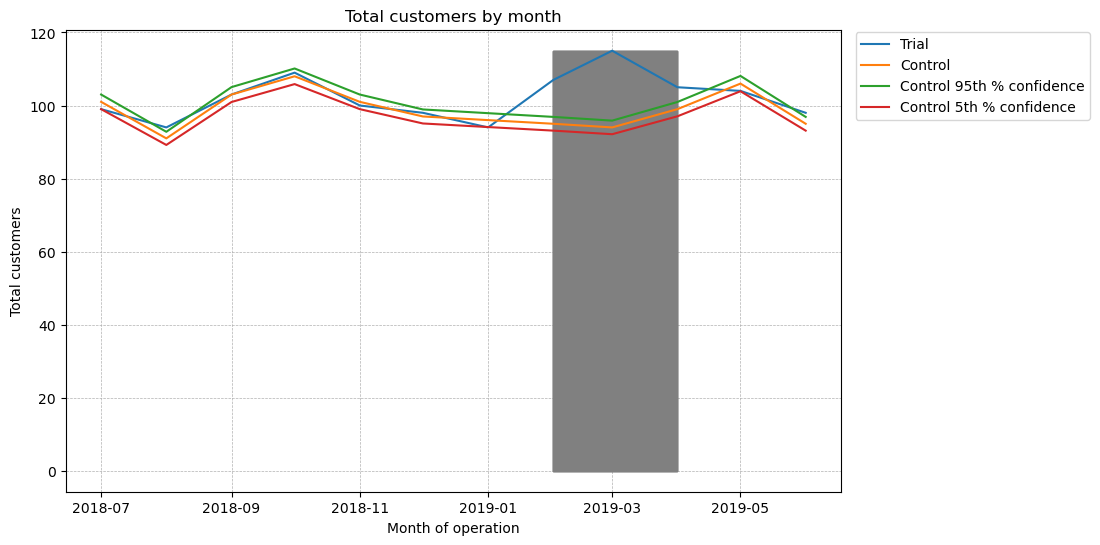

In [67]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=trialAssessment_cust, x='YEAR_MONTH', y='nCustomers',  hue='Store_Type')
plt.rc('axes', axisbelow=True)

# Customize plot
plt.xlabel('Month of operation')
plt.ylabel('Total customers')
plt.title('Total customers by month')
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.fill_between(trialAssessment_cust.YEAR_MONTH, trialAssessment_cust.nCustomers.max(),\
                 where= (trialAssessment_cust.YEAR_MONTH<'2019-05') & (trialAssessment_cust.YEAR_MONTH>'2019-01'), color='grey')
plt.show()

It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as above we saw, sales were not significantly higher.

## Trial Store 88

In [68]:
trial_store = 88
corr_nSales = storecorr(preTrial, 'totSales', trial_store)
corr_nCustomers = storecorr(preTrial, 'nCustomers', trial_store)

In [69]:
magnitude_nSales = calculateMagnitudeDistance(preTrial, 'totSales', trial_store)
magnitude_nCustomers  = calculateMagnitudeDistance(preTrial, 'nCustomers', trial_store)

In [70]:
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on = ['Store1', 'Store2'])
score_nSales['scoreNSales'] = score_nSales['Corr'] * corr_weight + score_nSales['mag_measure'] * (1-corr_weight)
score_nSales

,Store1,Store2,Corr,mag_measure,scoreNSales
0,88,1,0.813636,0.142778,0.478207
1,88,2,-0.067927,0.115785,0.023929
2,88,3,-0.507847,0.802657,0.147405
3,88,4,-0.745566,0.897742,0.076088
4,88,5,0.19033,0.610402,0.400366
...,...,...,...,...,...
255,88,268,-0.021429,0.161014,0.069793
256,88,269,-0.172578,0.709953,0.268688
257,88,270,-0.723272,0.714833,-0.004219
258,88,271,-0.103037,0.613300,0.255131


In [71]:
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on = ['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['Corr'] * corr_weight + score_nCustomers['mag_measure'] * (1-corr_weight)

In [72]:
store_Control = pd.merge(score_nSales, score_nCustomers, on = ['Store1', 'Store2'])
store_Control['finalControlScore'] = store_Control['scoreNCust'] * 0.5 + store_Control['scoreNSales'] * 0.5
store_Control = store_Control.sort_values(by='finalControlScore', ascending=False).reset_index(drop=True)
store_Control

,Store1,Store2,Corr_x,mag_measure_x,scoreNSales,Corr_y,mag_measure_y,scoreNCust,finalControlScore
0,88,88,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0
1,88,237,0.308479,0.956085,0.632282,0.947326,0.987586,0.967456,0.799869
2,88,178,0.731857,0.695904,0.71388,0.939466,0.821154,0.88031,0.797095
3,88,69,0.450029,0.707784,0.578906,0.815792,0.868984,0.842388,0.710647
4,88,113,0.495763,0.682644,0.589203,0.862632,0.784059,0.823346,0.706274
...,...,...,...,...,...,...,...,...,...
255,88,90,-0.662427,0.181834,-0.240296,-0.503735,0.322986,-0.090374,-0.165335
256,88,258,0.087493,0.014815,0.051154,-0.82585,0.017773,-0.404039,-0.176442
257,88,141,-0.69059,0.201172,-0.244709,-0.547399,0.299814,-0.123792,-0.18425
258,88,239,-0.642329,0.253431,-0.194449,-0.660672,0.304303,-0.178185,-0.186317


In [73]:
control_store = store_Control['Store2'][1]
control_store

237

In [74]:
measureOverTimeSales = measures 
measureOverTimeSales

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,nTxn,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,controlSales,controlCustomers
0,1,2018-07,206.9,49,52,62,1.061224,1.192308,3.337097,Others,NaN,NaN
1,1,2018-08,176.1,42,43,54,1.023810,1.255814,3.261111,Others,NaN,NaN
2,1,2018-09,278.8,59,62,75,1.050847,1.209677,3.717333,Others,NaN,NaN
3,1,2018-10,188.1,44,45,58,1.022727,1.288889,3.243103,Others,NaN,NaN
4,1,2018-11,192.6,46,47,57,1.021739,1.212766,3.378947,Others,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3164,272,2019-02,395.5,45,48,91,1.066667,1.895833,4.346154,Others,NaN,NaN
3165,272,2019-03,442.3,50,53,101,1.060000,1.905660,4.379208,Others,NaN,NaN
3166,272,2019-04,445.1,54,55,105,1.018519,1.909091,4.239048,Others,NaN,NaN
3167,272,2019-05,314.6,34,40,71,1.176471,1.775000,4.430986,Others,NaN,NaN


In [75]:
for i in range(len(measureOverTimeSales)) :
    if measureOverTimeSales.loc[i, 'STORE_NBR'] == trial_store :
        measureOverTimeSales.loc[i, 'Store_Type'] = 'Trial'
    elif measureOverTimeSales.loc[i, 'STORE_NBR'] == control_store :
        measureOverTimeSales.loc[i, 'Store_Type'] = 'Control'
    else : 
        measureOverTimeSales.loc[i, 'Store_Type'] = 'Others'

In [76]:
measure_preTrial = measureOverTimeSales[measureOverTimeSales['YEAR_MONTH'] < '2019-03']
pastSales = measure_preTrial.pivot_table(index='YEAR_MONTH', columns='Store_Type', values='totSales', aggfunc='mean')

<Figure size 800x600 with 0 Axes>

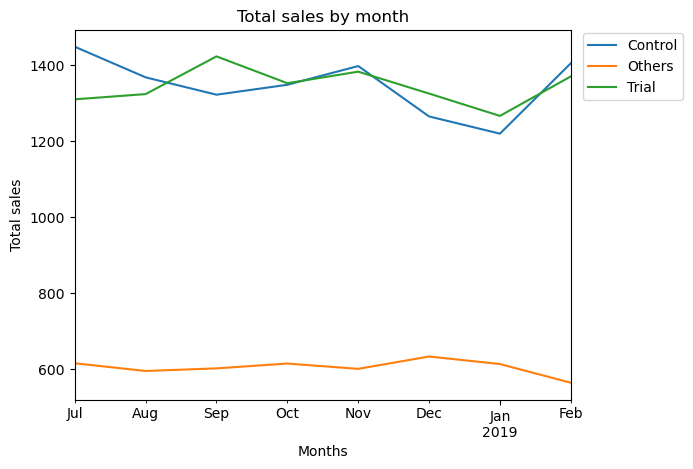

In [77]:
plt.figure(figsize=[8,6])
pastSales.plot()
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.title('Total sales by month')
plt.ylabel('Total sales')
plt.xlabel('Months')
plt.show()

<Figure size 800x600 with 0 Axes>

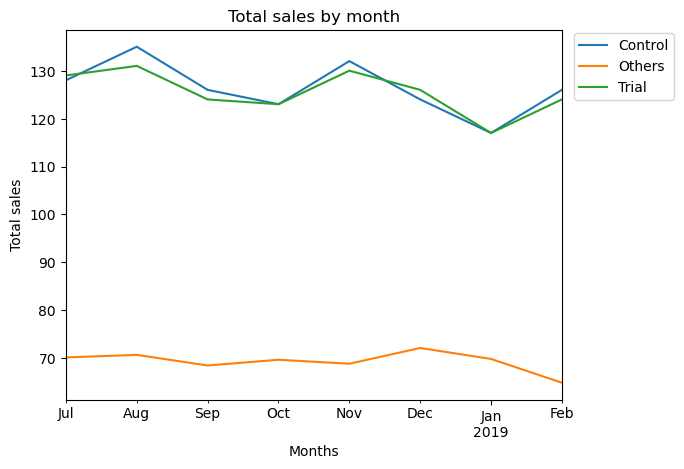

In [78]:
pastCust = measure_preTrial.pivot_table(index='YEAR_MONTH', columns='Store_Type', values='nCustomers', aggfunc='mean')

plt.figure(figsize=[8,6])
pastCust.plot()
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.title('Total sales by month')
plt.ylabel('Total sales')
plt.xlabel('Months')
plt.show()

### Assessment of Trial

#### Total sales

In [79]:
trial_sales = preTrial.loc[(preTrial['STORE_NBR'] == trial_store) & (preTrial['YEAR_MONTH'] < '2019-02'), 'totSales'].sum()
control_sales = preTrial.loc[(preTrial['STORE_NBR'] == control_store) & (preTrial['YEAR_MONTH'] < '2019-02'), 'totSales'].sum()
scalingFactorForControlSales = trial_sales / control_sales

In [80]:
scaledSales = measureOverTimeSales
scaledSales['controlSales'] = scaledSales.loc[scaledSales['STORE_NBR'] == control_store,\
                                                        'totSales']*scalingFactorForControlSales
scaledControlSales = scaledSales[scaledSales['STORE_NBR'] == control_store]
scaledControlSales

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,nTxn,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,controlSales,controlCustomers
2747,237,2018-07,1448.4,128,162,324,1.265625,2.000000,4.470370,Control,1450.657086,NaN
2748,237,2018-08,1367.8,135,165,313,1.222222,1.896970,4.369968,Control,1369.931485,NaN
2749,237,2018-09,1322.2,126,149,299,1.182540,2.006711,4.422074,Control,1324.260425,NaN
2750,237,2018-10,1348.3,123,147,299,1.195122,2.034014,4.509365,Control,1350.401097,NaN
2751,237,2018-11,1397.6,132,161,320,1.219697,1.987578,4.367500,Control,1399.777923,NaN
2752,237,2018-12,1265.0,124,144,289,1.161290,2.006944,4.377163,Control,1266.971288,NaN
2753,237,2019-01,1219.7,117,139,277,1.188034,1.992806,4.403249,Control,1221.600696,NaN
2754,237,2019-02,1404.8,126,157,314,1.246032,2.000000,4.473885,Control,1406.989143,NaN
2755,237,2019-03,1208.2,119,134,274,1.126050,2.044776,4.409489,Control,1210.082775,NaN
2756,237,2019-04,1204.6,120,135,272,1.125000,2.014815,4.428676,Control,1206.477165,NaN


In [81]:
percentageDiff = pd.merge(scaledControlSales[['YEAR_MONTH','controlSales']],\
                          measures.loc[measures['STORE_NBR']==trial_store,['totSales','YEAR_MONTH']])

percentageDiff['percentageDiff'] = np.abs((percentageDiff['controlSales'] - percentageDiff['totSales'])/percentageDiff['controlSales'])

In [82]:
percentageDiff

,YEAR_MONTH,controlSales,totSales,percentageDiff
0,2018-07,1450.657086,1310.00,0.096961
1,2018-08,1369.931485,1323.80,0.033674
2,2018-09,1324.260425,1423.00,0.074562
3,2018-10,1350.401097,1352.40,0.001480
4,2018-11,1399.777923,1382.80,0.012129
5,2018-12,1266.971288,1325.20,0.045959
6,2019-01,1221.600696,1266.40,0.036673
7,2019-02,1406.989143,1370.20,0.026147
8,2019-03,1210.082775,1477.20,0.220743
9,2019-04,1206.477165,1439.40,0.193060


In [83]:
stdDev = np.std(percentageDiff.loc[percentageDiff['YEAR_MONTH']<'2019-02', 'percentageDiff'])
dof = 8 - 1
percentageDiff['tValues'] = (percentageDiff['percentageDiff'] - 0)/stdDev
percentageDiff.loc[(percentageDiff['YEAR_MONTH']<'2019-05') & (percentageDiff['YEAR_MONTH']>'2019-01'), ['tValues','YEAR_MONTH']]

,tValues,YEAR_MONTH
7,0.843868,2019-02
8,7.124136,2019-03
9,6.230721,2019-04


In [84]:
from scipy.stats import t
percentile = t.ppf(0.95, df=dof)
percentile

1.894578605061305

T-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

In [85]:
pastSales_1 = measureOverTimeSales.loc[(measureOverTimeSales['Store_Type']=='Trial') | \
                                       (measureOverTimeSales['Store_Type']=='Control'),\
                                       ['YEAR_MONTH','Store_Type','totSales']]

In [86]:
pastSales_Controls95 = pastSales_1[pastSales_1['Store_Type'] == 'Control']
pastSales_Controls95['totSales'] = pastSales_1['totSales'] * (1 + stdDev * 2) 
pastSales_Controls95['Store_Type'] = 'Control 95th % confidence'

pastSales_Controls5 = pastSales_1[pastSales_1['Store_Type'] == 'Control']
pastSales_Controls5['totSales'] = pastSales_1['totSales'] * (1 - stdDev * 2) 
pastSales_Controls5['Store_Type'] = 'Control 5th % confidence'

/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/2125521922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls95['totSales'] = pastSales_1['totSales'] * (1 + stdDev * 2)
/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/2125521922.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls95['Store_Type'] = 'Control 95th % confidence'
/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/2125521922.py:6: SettingWithCopyWarning: 
A valu

In [87]:
trialAssessment = pd.concat([pastSales_1 , pastSales_Controls95, pastSales_Controls5], axis=0)
trialAssessment['YEAR_MONTH'] = trialAssessment['YEAR_MONTH'].dt.to_timestamp()
trialAssessment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 1001 to 2758
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   YEAR_MONTH  48 non-null     datetime64[ns]
 1   Store_Type  48 non-null     object        
 2   totSales    48 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.5+ KB


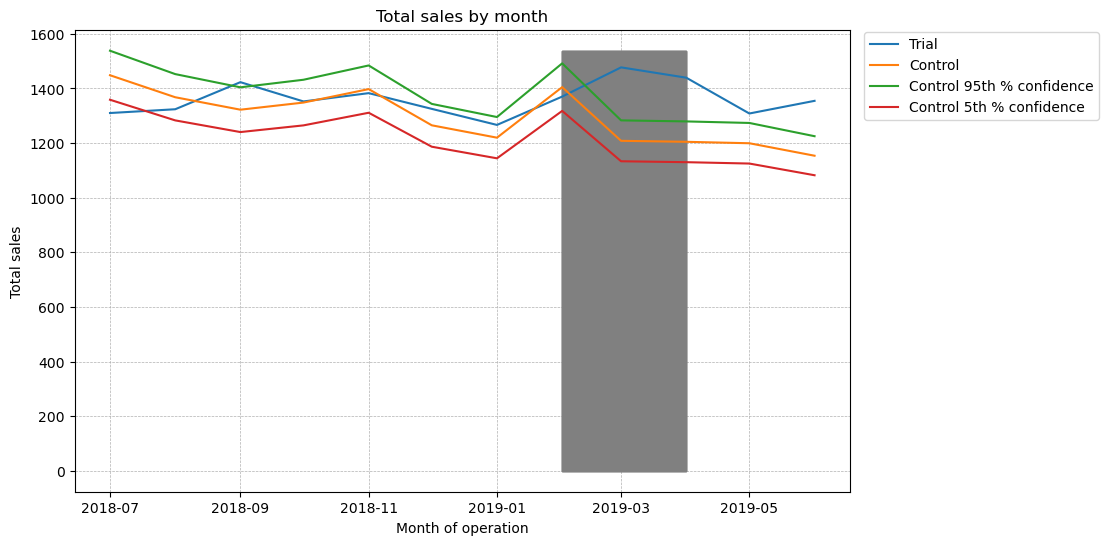

In [88]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=trialAssessment, x='YEAR_MONTH', y='totSales',  hue='Store_Type')
plt.rc('axes', axisbelow=True)

# Customize plot
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.fill_between(trialAssessment.YEAR_MONTH, trialAssessment.totSales.max(),\
                 where= (trialAssessment.YEAR_MONTH<'2019-05') & (trialAssessment.YEAR_MONTH>'2019-01'), color='grey')
plt.show()

The trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.

In [89]:
preTrial

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,nTxn,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,2018-07,206.9,49,52,62,1.061224,1.192308,3.337097
1,1,2018-08,176.1,42,43,54,1.023810,1.255814,3.261111
2,1,2018-09,278.8,59,62,75,1.050847,1.209677,3.717333
3,1,2018-10,188.1,44,45,58,1.022727,1.288889,3.243103
4,1,2018-11,192.6,46,47,57,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...,...,...
3159,272,2018-09,304.7,32,36,71,1.125000,1.972222,4.291549
3160,272,2018-10,430.6,44,50,99,1.136364,1.980000,4.349495
3161,272,2018-11,376.2,41,45,87,1.097561,1.933333,4.324138
3162,272,2018-12,403.9,47,47,89,1.000000,1.893617,4.538202


#### Number of customers

In [90]:
trial_cust = preTrial.loc[(preTrial['STORE_NBR'] == trial_store) & (preTrial['YEAR_MONTH'] < '2019-02'), 'nCustomers'].sum()
control_cust = preTrial.loc[(preTrial['STORE_NBR'] == control_store) & (preTrial['YEAR_MONTH'] < '2019-02'), 'nCustomers'].sum()
scalingFactorForControlCust = trial_cust / control_cust

scaledCust = measureOverTimeSales
scaledCust['controlCustomers'] = scaledCust.loc[scaledCust['STORE_NBR'] == control_store,\
                                                        'nCustomers']*scalingFactorForControlCust
scaledControlCust = scaledCust[scaledCust['STORE_NBR'] == control_store]

In [91]:
percentageDiff_cust = pd.merge(scaledControlCust[['YEAR_MONTH','controlCustomers']],\
                          measures.loc[measures['STORE_NBR']==trial_store,['nCustomers','YEAR_MONTH']])

percentageDiff_cust['percentageDiff'] = np.abs((percentageDiff_cust['controlCustomers'] - percentageDiff_cust['nCustomers'])/percentageDiff_cust['controlCustomers'])

In [92]:
percentageDiff_cust

,YEAR_MONTH,controlCustomers,nCustomers,percentageDiff
0,2018-07,127.276836,129,0.013539
1,2018-08,134.237288,131,0.024116
2,2018-09,125.288136,124,0.010281
3,2018-10,122.305085,123,0.005682
4,2018-11,131.254237,130,0.009556
5,2018-12,123.299435,126,0.021902
6,2019-01,116.338983,117,0.005682
7,2019-02,125.288136,124,0.010281
8,2019-03,118.327684,134,0.132448
9,2019-04,119.322034,128,0.072727


In [93]:
stdDev_cust = np.std(percentageDiff_cust.loc[percentageDiff_cust['YEAR_MONTH']<'2019-02', 'percentageDiff'])
percentageDiff_cust['tValues'] = (percentageDiff_cust['percentageDiff'] - 0)/stdDev_cust
percentageDiff_cust.loc[(percentageDiff_cust['YEAR_MONTH']<'2019-05') & (percentageDiff_cust['YEAR_MONTH']>'2019-01'), ['tValues','YEAR_MONTH']]

,tValues,YEAR_MONTH
7,1.498623,2019-02
8,19.305795,2019-03
9,10.600788,2019-04


In [94]:
pastCustomer = measureOverTimeSales.loc[(measureOverTimeSales['Store_Type']=='Trial') | \
                                       (measureOverTimeSales['Store_Type']=='Control'),\
                                       ['YEAR_MONTH','Store_Type','nCustomers']]

pastCustomer_Controls95 = pastCustomer[pastCustomer['Store_Type'] == 'Control']
pastCustomer_Controls95['nCustomers'] = pastCustomer['nCustomers'] * (1 + stdDev_cust * 2) 
pastCustomer_Controls95['Store_Type'] = 'Control 95th % confidence'

pastCustomer_Controls5 = pastCustomer[pastCustomer['Store_Type'] == 'Control']
pastCustomer_Controls5['nCustomers'] = pastCustomer['nCustomers'] * (1 - stdDev_cust * 2) 
pastCustomer_Controls5['Store_Type'] = 'Control 5th % confidence'

/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/863260651.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastCustomer_Controls95['nCustomers'] = pastCustomer['nCustomers'] * (1 + stdDev_cust * 2)
/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/863260651.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastCustomer_Controls95['Store_Type'] = 'Control 95th % confidence'
/var/folders/n0/xw6g2kgs5w144rl4gvd64kcm0000gn/T/ipykernel_31986/863260651.py:10: SettingWithCopyWa

In [95]:
trialAssessment_cust = pd.concat([pastCustomer , pastCustomer_Controls95, pastCustomer_Controls5], axis=0)
trialAssessment_cust['YEAR_MONTH'] = trialAssessment_cust['YEAR_MONTH'].dt.to_timestamp()
trialAssessment_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 1001 to 2758
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   YEAR_MONTH  48 non-null     datetime64[ns]
 1   Store_Type  48 non-null     object        
 2   nCustomers  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.5+ KB


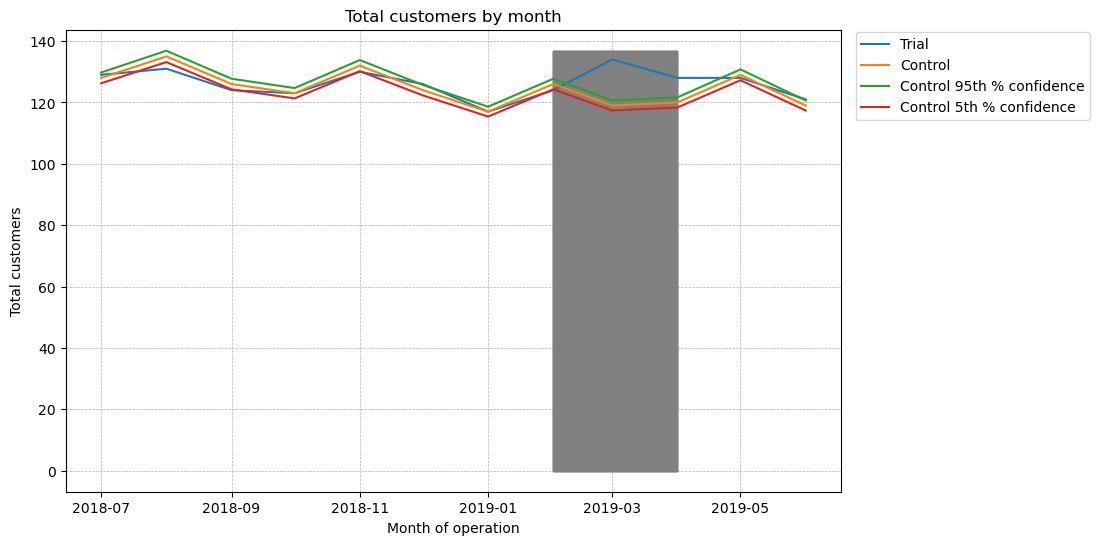

In [96]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=trialAssessment_cust, x='YEAR_MONTH', y='nCustomers',  hue='Store_Type')
plt.rc('axes', axisbelow=True)

# Customize plot
plt.xlabel('Month of operation')
plt.ylabel('Total customers')
plt.title('Total customers by month')
plt.legend(bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.fill_between(trialAssessment_cust.YEAR_MONTH, trialAssessment_cust.nCustomers.max(),\
                 where= (trialAssessment_cust.YEAR_MONTH<'2019-05') & (trialAssessment_cust.YEAR_MONTH>'2019-01'), color='grey')
plt.show()

Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

## Conclusion

There are three control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.

The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. It might need to check with the store manager if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales.